In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 9.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=52bd6bd4dc3ee0de4468856d18665552e950e5a8044e60edce0946cbc5103752
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [2]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from transformers import T5Model, T5TokenizerFast
import networkx as nx
from torch_geometric.data import Data
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch_geometric.data import Batch
from transformers import T5Model
from torch_geometric.nn import GCNConv
from datasets import load_dataset
from torch_geometric.data import Data
from transformers import T5TokenizerFast
import networkx as nx
import torch
import re
import matplotlib.pyplot as plt

model_name = "t5-small"


class WebNLGDataset(Dataset):
    def __init__(self, dataset, max_edges=512):
        self.dataset = dataset
        self.tokenizer = T5TokenizerFast.from_pretrained(model_name)
        self.node_to_idx = {}  # Node to index mapping
        self.max_edges = max_edges

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data_dict = self.dataset[idx]
        text = data_dict['lex']['text'][0]
        triples = data_dict['original_triple_sets']['otriple_set'][0]

        graph_nx = self.triples_to_graph(triples)
        edge_index = self.get_edge_index(graph_nx)

        encoding = self.tokenizer.encode_plus(text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')

        graph_data = Data(x=encoding['input_ids'].squeeze(dim=0), edge_index=edge_index)
        graph_data.attention_mask = encoding['attention_mask'].squeeze(dim=0)
        graph_data.y = encoding['input_ids'].squeeze(dim=0)
        
        #print("Original Sample: \n", text, "\n", triples)  # Print the original sample      
        #print("NetworkX Graph: \n", graph_nx.edges) # Print the NetworkX graph
        #self.visualize_graph(graph_nx)

        return graph_data

    def triples_to_graph(self, triples):
        self.node_to_idx = {}  # reset for each new graph
        graph_nx = nx.MultiDiGraph()
        for triple in triples:
            triple = re.sub(r'\([^)]*\)', '', triple).split('|')  # remove brackets and split by '|'
            subject, relation, obj = map(str.strip, triple)

            # Add string node names to the graph
            if subject not in self.node_to_idx:
                self.node_to_idx[subject] = len(self.node_to_idx)
            if obj not in self.node_to_idx:
                self.node_to_idx[obj] = len(self.node_to_idx)

            graph_nx.add_edge(subject, obj, key=relation)
        return graph_nx

    def get_edge_index(self, graph_nx):
        edge_index = torch.tensor([[self.node_to_idx[n] for n in edge[:2]] for edge in graph_nx.edges]).t().contiguous()
        return edge_index
    
    def visualize_graph(self, graph_nx):
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(graph_nx)  # positions for all nodes
        nx.draw(graph_nx, pos, with_labels=True)
        labels = nx.get_edge_attributes(graph_nx, 'key')
        nx.draw_networkx_edge_labels(graph_nx, pos, edge_labels=labels)
        plt.show()

    
class AdapterBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AdapterBlock, self).__init__()
        self.layer_norm = nn.LayerNorm(input_dim, eps=1e-6)
        self.gcn = GCNConv(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, input_dim)  # Restore dimension to input_dim
        self.res_fc = nn.Linear(input_dim, input_dim)  # Transform the residual

    def forward(self, x, edge_index):
        x_res = self.res_fc(x)  # Transform the residual tensor
        x = self.layer_norm(x)
        x = self.gcn(x, edge_index)
        x = self.relu(x)
        x = self.fc(x)
        return x + x_res  # Now you can add the tensors


class TransformerGCN(nn.Module):
    def __init__(self, vocab_size, adapter_dim):
        super(TransformerGCN, self).__init__()
        self.transformer = T5Model.from_pretrained(model_name)
        self.hidden_size = self.transformer.config.hidden_size  # Get the hidden size from the config
        self.reduce_dim = nn.Linear(self.hidden_size, adapter_dim)  # Use the hidden size instead of 768

        # Freeze the parameters of the T5 model
        for param in self.transformer.parameters():
            param.requires_grad = False

        self.adapter_blocks = nn.ModuleList([
        AdapterBlock(block.layer[1].DenseReluDense.wo.weight.size(0), adapter_dim) for block in self.transformer.encoder.block
        ])

        self.output_head = nn.Linear(adapter_dim, vocab_size)

    def forward(self, input_ids, attention_mask, edge_index):
        if input_ids.dim() == 1:  # If the input is 1D (batch size 1)
            input_ids = input_ids.unsqueeze(0)  # Add a batch dimension
        if attention_mask.dim() == 1:  # Same for the attention_mask
            attention_mask = attention_mask.unsqueeze(0)

        shifted_input_ids = torch.cat([torch.zeros((input_ids.size(0), 1), dtype=torch.long, device=input_ids.device), input_ids[:, :-1]], dim=-1)

        input_embeds = self.transformer.get_input_embeddings()(input_ids)
        hidden_states = input_embeds
        for block, adapter_block in zip(self.transformer.encoder.block, self.adapter_blocks):
            hidden_states, _ = block(hidden_states, attention_mask=attention_mask, encoder_hidden_states=None, encoder_attention_mask=None)
            hidden_states = adapter_block(hidden_states, edge_index)

        transformer_outputs = self.transformer(inputs_embeds=hidden_states, attention_mask=attention_mask, decoder_input_ids=shifted_input_ids)
        transformer_outputs = self.reduce_dim(transformer_outputs.last_hidden_state)
        return self.output_head(transformer_outputs)


class ModifiedT5Block(nn.Module):
    def __init__(self, original_block, adapter_dim):
        super(ModifiedT5Block, self).__init__()
        self.original_block = original_block
        self.adapter = AdapterBlock(original_block.layer[1].DenseReluDense.wi.weight.size(-1), adapter_dim)

    def forward(self, x, edge_index, **kwargs):
        x, _ = self.original_block(x, **kwargs)
        return self.adapter(x, edge_index)



from torch_geometric.data import DataLoader as GeometricDataLoader

def train(model, dataloader, epochs, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    tokenizer = T5TokenizerFast.from_pretrained(model_name)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    for epoch in range(epochs):
        model.train()
        for data in tqdm(dataloader):
            data = data.to(device) # Moving batch to device
            optimizer.zero_grad()

            outputs = model(input_ids=data.x, attention_mask=data.attention_mask, edge_index=data.edge_index)
            loss = criterion(outputs.view(-1, outputs.size(-1)), data.y.view(-1))
            loss.backward()
            optimizer.step()

# Usage
dataset_dict = load_dataset('web_nlg', 'webnlg_challenge_2017')['train']
dataset = WebNLGDataset(dataset_dict)
vocab_size = len(dataset.tokenizer)
model = TransformerGCN(vocab_size=vocab_size, adapter_dim=512)
dataloader = GeometricDataLoader(dataset, batch_size=5)
train(model, dataloader, epochs=1, device=torch.device('cuda'))


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Generating train split:   0%|          | 0/6940 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4615 [00:00<?, ? examples/s]

Dataset web_nlg downloaded and prepared to /root/.cache/huggingface/datasets/web_nlg/webnlg_challenge_2017/0.0.0/28ffb892f7f42450dd9558684aa43bcaf44b1b3bf0d77cb8d73534646af88dda. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 1388/1388 [13:33<00:00,  1.71it/s]


In [4]:
train(model, dataloader, epochs=4, device=torch.device('cuda'))

100%|██████████| 1377/1377 [03:36<00:00,  6.35it/s]


In [5]:
def test(model, dataloader, device):
    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            outputs = model(input_ids=data.x, attention_mask=data.attention_mask, edge_index=data.edge_index)
            
            # Get the predicted token ids by taking the argmax over the token dimension
            predicted_ids = outputs.argmax(-1)
            
            # Convert the tensor outputs to text using the tokenizer
            output_text = [dataset.tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in predicted_ids]

            # print input and output
            print(f"Input: {dataset.tokenizer.decode(data.x, skip_special_tokens=True)}")
            print(f"Output: {output_text}")

# Usage
dataset_dict = load_dataset('web_nlg', 'webnlg_challenge_2017')['test']
dataset_dict = [sample for sample in dataset_dict if sample['lex']['text']] # filter out samples with empty targets 
dataset = WebNLGDataset(dataset_dict)
dataloader = GeometricDataLoader(dataset, batch_size=2)
test(model, dataloader, device=torch.device('cuda'))


  0%|          | 0/3 [00:00<?, ?it/s]

Input: Aaron S Daggett was awarded the Purple Heart. The Battle of Mine Run was one fought by Aaron S Daggett.
Output: ['The Turner Daggett was born the Purple Hearts music The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The

KeyboardInterrupt: 

Original Sample: 
 The city of Aarhus in Denmark is the location of the School of Business and Social Sciences at the Aarhus University which was established in 1928 and affiliated with the European University Association headquartered in Brussels. The current Dean is Thomas Pallesen and there are 16000 students. 
 ['Aarhus_University,_School_of_Business_and_Social_Sciences | dean | "Thomas Pallesen"@en', 'Aarhus_University,_School_of_Business_and_Social_Sciences | city | Aarhus', 'Aarhus_University,_School_of_Business_and_Social_Sciences | numberOfStudents | "16000"^^xsd:nonNegativeInteger', 'European_University_Association | headquarters | Brussels', 'Aarhus_University,_School_of_Business_and_Social_Sciences | country | Denmark', 'Aarhus_University,_School_of_Business_and_Social_Sciences | affiliations | European_University_Association', 'Aarhus_University,_School_of_Business_and_Social_Sciences | established | 1928']
NetworkX Graph: 
 [('Aarhus_University,_School_of_Business_and_Soc

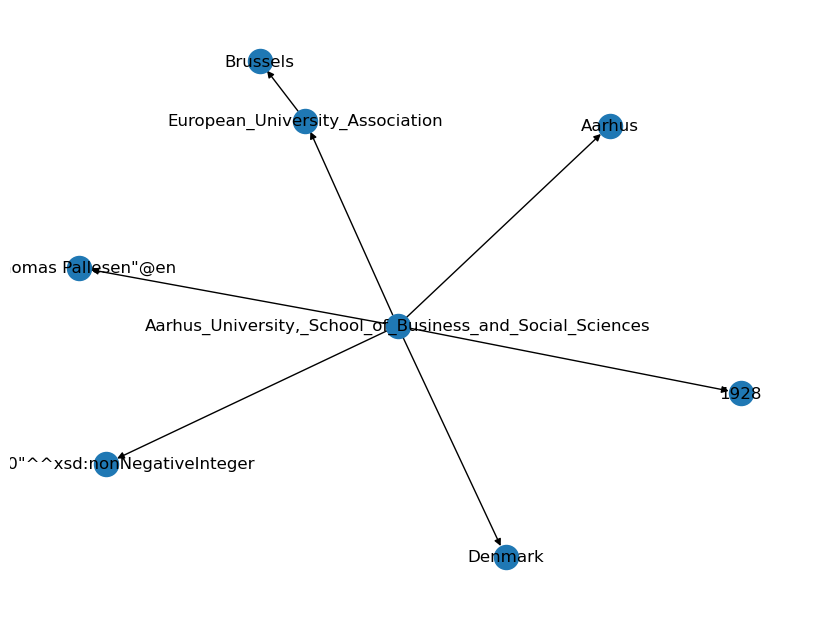

Data(x=[512], edge_index=[2, 7], attention_mask=[512], y=[512])

In [19]:
# Print the postprocessed output for the first item in the dataset
dataset[-3]